In [1]:
# Imports, activation (nonlinear) functions, and Network class
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pickle

warnings.filterwarnings('ignore')

with open("mnist.pkl",'rb') as inp:
    mnist = pickle.load(inp)
x_train, t_train, x_test, t_test = mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_der(x):
    expx = np.exp(-x)
    return expx/np.power(1 + expx,2)

def identity(x):
    return x

def identity_der(x):
    return 1

def random_weights(layers):
    weights = [None]*(len(layers) - 1)
    for i in range(len(layers) - 1):
        weights[i] = np.random.normal(0,1,(layers[i+1][0],layers[i][0]))
    return weights

# Network class - contains all required functions
class Network:
    """Feed forward neural network to be trained"""

    def __init__(self, layers, weights):
        self.layers = layers
        self.weights = weights

    def forward_propagate_all(self, sample):
        """Returns the states (raw, activated) of ALL layers"""
        states = [None]*len(self.layers)
        my_sample = np.copy(sample)
        states[0] = (my_sample, self.layers[0][1](my_sample))

        for i in range(len(self.weights)):
            mult = np.matmul(self.weights[i],states[i][1])
            states[i+1] = (mult, self.layers[i+1][1](mult))

        return states
    
    def forward_propagate(self, sample):
        """Returns the activated state of the LAST layer"""
        state = self.layers[0][1](np.copy(sample))
        for i in range(len(self.weights)):
            state = self.layers[i+1][1](np.matmul(self.weights[i],state))
        return state
    
    def back_propagate(self, sample, output):
        """Uses chain rule to calculate gradient for each weight with respect to the error of the network"""
        states = self.forward_propagate_all(sample)
        L = len(self.layers) - 1
        dCdz = [None]*len(self.layers)
        dCdW = [None]*len(self.weights)

        # Chain rule for last layer and other layers recursively
        # \frac{\del C}{\del z} = \frac{\del C}{\del a^L}\frac{\del a^L}{\del z^L}
        dCdz[L] = (states[L][1] - output) * self.layers[L][2](states[L][0])
        for l in range(L - 1, -1, -1):
            dCdz[l] = np.matmul(np.transpose(self.weights[l]), dCdz[l + 1]) * self.layers[l][2](states[l][0])
            dCdW[l] = np.matmul(dCdz[l+1], np.transpose(states[l][1]))
        # (final error, weight gradient)
        return (states[L][1] - output, dCdW)
    
    def train(self, sample, output, learning_rate, target_error, group_size, iteration_update = 1000):
        # Precalculate the error threshold
        threshold = target_error * group_size

        # Iterate a maximum number of times, even if error threshold isn't reached
        for iteration in range(1000000):
            # Take a small 'slice' from the sample and output to use as a batch for training
            slice_left = (iteration * group_size) % sample.shape[1]
            slice_right = np.minimum((iteration * group_size) % sample.shape[1] + group_size, sample.shape[1])
            small_sample = sample[:, slice_left:slice_right]
            small_output = output[:, slice_left:slice_right]
            bprop = self.back_propagate(small_sample, small_output)
            
            error_vec = np.ravel(bprop[0])
            error = np.dot(error_vec,error_vec) # Take squared norm of error
            if error < threshold:
                print("Error: " + str(error))
                break
            elif iteration % iteration_update == 0:
                print("Error: " + str(error))

            # Move weights in direction of steepest cost function decline
            for l in range(len(self.weights)):
                self.weights[l] = self.weights[l] - learning_rate * bprop[1][l]

In [ ]:
# Training - ONLY run if you want to retrain (overwrite) the existing network
# ----------------------------------------------------------------------------------------
with open('model.pkl', 'wb') as outp:
    v_sigmoid = np.vectorize(sigmoid)
    v_sigmoid_der = np.vectorize(sigmoid_der)

    layers = [[784, np.vectorize(identity), np.vectorize(identity_der)],[16, v_sigmoid, v_sigmoid_der], [16, v_sigmoid, v_sigmoid_der], [10, v_sigmoid, v_sigmoid_der]]
    nn = Network(layers, random_weights(layers))

    # This unpacks the testing data from [4,2,0,...] to [[0,0,0,0,1,0,0,0,0,0],...]
    t_train_expanded = np.zeros((10,len(t_train)))
    for i in range(len(t_train)):
        t_train_expanded[t_train[i]][i] = 1

    nn.train(x_train.transpose()/255, t_train_expanded, 0.1, 0.005, 100)
    pickle.dump(nn, outp, pickle.HIGHEST_PROTOCOL)
# ----------------------------------------------------------------------------------------

In [2]:
# Import existing model
with open('model.pkl', 'rb') as inp:
    nn = pickle.load(inp)

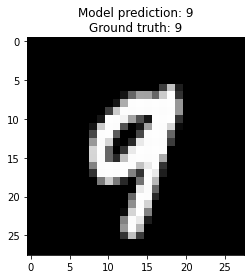

In [22]:
# Test model
i = np.random.randint(0,10000)
plt.imshow(x_test[i,:].reshape(28,28), cmap='gray')
plt.gcf().set_facecolor("white")
plt.title("Model prediction: " + str(np.argmax(nn.forward_propagate(x_test[i,:].transpose()/255), axis=0)) + "\n" + "Ground truth: " + str(t_test[i]))
plt.show()